In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[2]").appName("Credit Card Fraud Detection").getOrCreate()
spark

In [3]:
# Imported Libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import collections

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [4]:
#load dataset
df = spark.read.format("csv").option("header",True).option("inferSchema",True).load("E:\\4th year\\WIN_20_21\\5_BIG_DATA\\creditcard.csv")
df.show(1)


+----+----------------+-------------------+----------------+----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|              V4|                V5|               V6|               V7|                V8|               V9|               V10|               V11|               V12|               V13|               V14|             V15|               V16|              V17|               V18|              V19|              V20|               V21|              V22|               V23|               V24|              V

In [5]:
df.count()

284807

In [6]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [7]:
#check for null values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [8]:
c_freq = df.groupBy("Class").count()
c_freq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

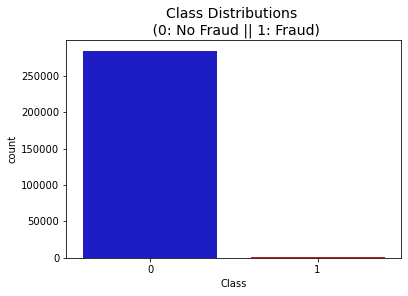

In [9]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [10]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [11]:
# preprocessing
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['S_Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['S_Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
scaled_amount = df['S_Amount']
scaled_time = df['S_Time']

df.drop(['S_Amount', 'S_Time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [13]:
# Random Under Sampling :

In [14]:

df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
57738,0.361909,-0.430515,-1.580160,0.010626,0.576008,1.064584,0.449331,-0.769895,-0.129385,0.445445,...,-0.229967,0.210301,0.325833,-0.508766,0.029304,-0.370012,-0.343463,0.117872,-0.225077,0
30496,1.253406,-0.572598,-4.844372,5.649439,-6.730396,5.252842,-4.409566,-1.740767,-6.311699,3.449167,...,0.284555,1.194888,-0.845753,0.190674,-0.216443,-0.325033,-0.270328,0.210214,0.391855,1
248532,0.191434,0.814072,-0.475402,1.376879,-0.708124,-0.156658,0.355415,-1.401416,0.861686,0.139076,...,0.010719,0.342560,1.053339,-0.126076,-0.028367,-0.387668,-0.144850,0.342176,0.242224,0
151807,0.161951,0.136268,-3.552173,5.426461,-3.731810,6.679062,-2.187543,2.433940,-8.748110,-12.108284,...,3.792667,-5.688990,2.510980,0.953933,-0.542506,-0.620152,0.406013,0.023025,0.164741,1
57615,-0.296793,-0.431279,-1.232804,2.244119,-1.703826,1.492536,-1.192985,-1.686110,-1.864612,0.856122,...,0.207889,0.560475,0.165682,-0.013754,0.474935,-0.218725,0.302809,0.466031,0.250134,1


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


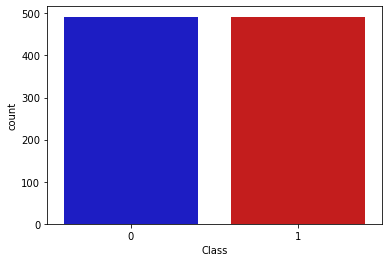

In [15]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.show()

In [16]:
#Model without under sampling:

In [17]:
# split train and test data
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [18]:
#logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [ ]:
# svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))    ##99%

In [ ]:
#decision tree
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))    ##99%

In [19]:
#Model with under sampling data:

In [20]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [21]:
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [25]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [26]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "  : ", round(training_score.mean(), 2) * 100, "% accuracy score")

LogisticRegression   :  94.0 % accuracy score
SVC   :  93.0 % accuracy score
DecisionTreeClassifier   :  89.0 % accuracy score


In [27]:
# find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [28]:
# Models fitted with UnderSampling
# predict test data

y_pred_log_reg = log_reg.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)


In [29]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        87
           1       1.00      0.88      0.94       110

    accuracy                           0.93       197
   macro avg       0.94      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197



In [30]:
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        87
           1       0.99      0.89      0.94       110

    accuracy                           0.93       197
   macro avg       0.93      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197



In [31]:
print('Decision Tree:')
print(classification_report(y_test, y_pred_tree))

Decision Tree:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        87
           1       0.98      0.88      0.93       110

    accuracy                           0.92       197
   macro avg       0.92      0.93      0.92       197
weighted avg       0.93      0.92      0.92       197

